# NOTEBOOK FOR GENERATE REPORT OF SVC AND MX CAMERA DATA

In [1]:
#Generic imports
import pandas as pd
import geopandas as gpd
import numpy as np
import os
from os.path import exists
import matplotlib.pyplot as plt
import seaborn as sb
from rasterstats import zonal_stats

#Local imports
from specdal import Collection, Spectrum

In [2]:
#Read channels stats data
path = "Z:/11-Projects/CERESTRES/04-Raw/SVC_HR1024i/Santaella/2022_04_22/df_stats_calibration_SVC_and_MX.csv"
df_stats = pd.read_csv(path)

In [3]:
#Calculate index SVC and MX Camera
#SVC
df_stats['NDVI_SVC'] = (df_stats['CH_infrared_SVC'] - df_stats['CH_red_SVC'])/(df_stats['CH_infrared_SVC'] + df_stats['CH_red_SVC'])
df_stats['GNDVI_SVC'] = (df_stats['CH_infrared_SVC'] - df_stats['CH_green_SVC'])/(df_stats['CH_infrared_SVC'] + df_stats['CH_green_SVC'])
df_stats['NDRE_SVC'] = (df_stats['CH_infrared_SVC'] - df_stats['CH_redEdge_SVC'])/(df_stats['CH_infrared_SVC'] + df_stats['CH_redEdge_SVC'])

#MX Camera
df_stats['NDVI_MX'] = (df_stats['MX_median_NIR'] - df_stats['MX_median_RED'])/(df_stats['MX_median_NIR'] + df_stats['MX_median_RED'])
df_stats['GNDVI_MX'] = (df_stats['MX_median_NIR'] - df_stats['MX_median_GREEN'])/(df_stats['MX_median_NIR'] + df_stats['MX_median_GREEN'])
df_stats['NDRE_MX'] = (df_stats['MX_median_NIR'] - df_stats['MX_median_REDEDGE'])/(df_stats['MX_median_NIR'] + df_stats['MX_median_REDEDGE'])

## Plotear gráficas de dispersión

In [4]:
from scipy import stats
def RMSE(df, p, x):
    return ((df[p] - df[x]) ** 2).mean() ** .5
    
def lregress(df, p, x):
    subset = df.dropna(subset=[p,x])
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset[x], subset[p])
    return(slope, intercept, r_value*r_value, p_value, std_err)

def validation_plot(x, y, data, title=None, x_label=None, y_label=None, alpha=.5, c=None, cmap='jet', ax=None, size=40):
    slope, intercept, r2, p_value, std_err = lregress(data, y, x)
    rmse = RMSE(data, y, x)
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if c is None:
        data.plot.scatter(x=x, y=y, marker='.', alpha=alpha, ax=ax, s=size)
    else:
        data.plot.scatter(x=x, y=y, marker='.', alpha=alpha, c=c, cmap=cmap, ax=ax, s=size)
    min_val = min(data[x].min(), data[y].min())
    max_val = max(data[x].max(), data[y].max())
    ax.plot([min_val,max_val], [min_val,max_val], c='black')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    val_text = "$r^2$: {r2:.5f}, slope: {slope:.2f}, intercept: {intercept:.5f}, RMSE: {rmse:.5f}".format(r2=r2, slope=slope, intercept=intercept, rmse=rmse)
    if title is None:
        ax.set_title("MX-drone ({x}) vs SVC ({y})\n{val}\n".format(x=x, y=y, val=val_text))
    else:
        ax.set_title(title)
    if x_label is not None:
        ax.set_xlabel(x_label)
    if y_label is not None:
        ax.set_ylabel(y_label)

### 1. Plot comparación de canales (azul, verde, etc.) entre SVC y MX

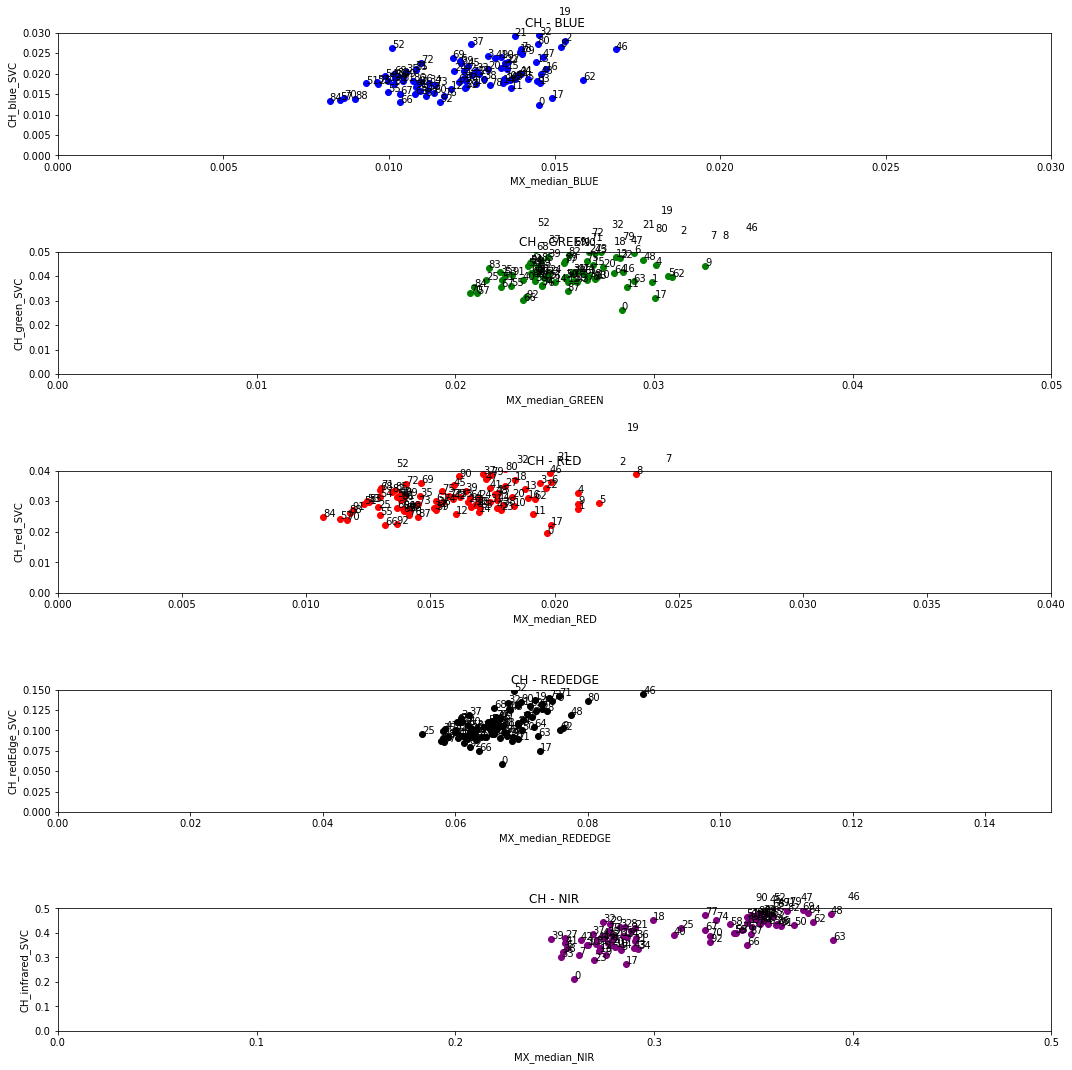

In [5]:
fig, axs = plt.subplots(5, figsize=(15,15))

#CHANNEL BLUE
for x, y, ids in zip(df_stats['MX_median_BLUE'], df_stats['CH_blue_SVC'], df_stats.index):
    axs[0].plot(x,y, 'o', c='blue')
    axs[0].text(x, y, '%s' % (ids))
    axs[0].set_title('CH - BLUE')
    axs[0].set_ylabel('CH_blue_SVC')
    axs[0].set_xlabel('MX_median_BLUE')
    axs[0].set_xlim(0,0.03)
    axs[0].set_ylim(0,0.03)  

#CHANNEL GREEN
for x, y, ids in zip(df_stats['MX_median_GREEN'], df_stats['CH_green_SVC'], df_stats.index):
    axs[1].plot(x,y, 'o', c='green')
    axs[1].text(x, y, '%s' % (ids))
    axs[1].set_title('CH - GREEN')
    axs[1].set_ylabel('CH_green_SVC')
    axs[1].set_xlabel('MX_median_GREEN')
    axs[1].set_xlim(0,0.05)
    axs[1].set_ylim(0,0.05) 
    
#CHANNEL RED
for x, y, ids in zip(df_stats['MX_median_RED'], df_stats['CH_red_SVC'], df_stats.index):
    axs[2].plot(x,y, 'o', c='red')
    axs[2].text(x, y, '%s' % (ids))
    axs[2].set_title('CH - RED')
    axs[2].set_ylabel('CH_red_SVC')
    axs[2].set_xlabel('MX_median_RED')
    axs[2].set_xlim(0,0.04)
    axs[2].set_ylim(0,0.04) 
    
#CHANNEL REDEDGE
for x, y, ids in zip(df_stats['MX_median_REDEDGE'], df_stats['CH_redEdge_SVC'], df_stats.index):
    axs[3].plot(x,y, 'o', c='k')
    axs[3].text(x, y, '%s' % (ids))
    axs[3].set_title('CH - REDEDGE')
    axs[3].set_ylabel('CH_redEdge_SVC')
    axs[3].set_xlabel('MX_median_REDEDGE')
    axs[3].set_xlim(0,0.15)
    axs[3].set_ylim(0,0.15) 
    
#CHANNEL NIR
for x, y, ids in zip(df_stats['MX_median_NIR'], df_stats['CH_infrared_SVC'], df_stats.index):
    axs[4].plot(x,y, 'o', c='purple')
    axs[4].text(x, y, '%s' % (ids))
    axs[4].set_title('CH - NIR')
    axs[4].set_ylabel('CH_infrared_SVC')
    axs[4].set_xlabel('MX_median_NIR')
    axs[4].set_xlim(0,0.5)
    axs[4].set_ylim(0,0.5) 
    
fig.tight_layout()

#TENGO QUE COMPROBAR QUE LAS REPRESENTACIONES SEAN DIFERENTES, AUNQUE A PRIORI PARECE QUE SÍ PORQUE HE TENIDO QUE CAMBIAR LA RESOLUCION.

## 2. Valores mediana - Comparación de canales

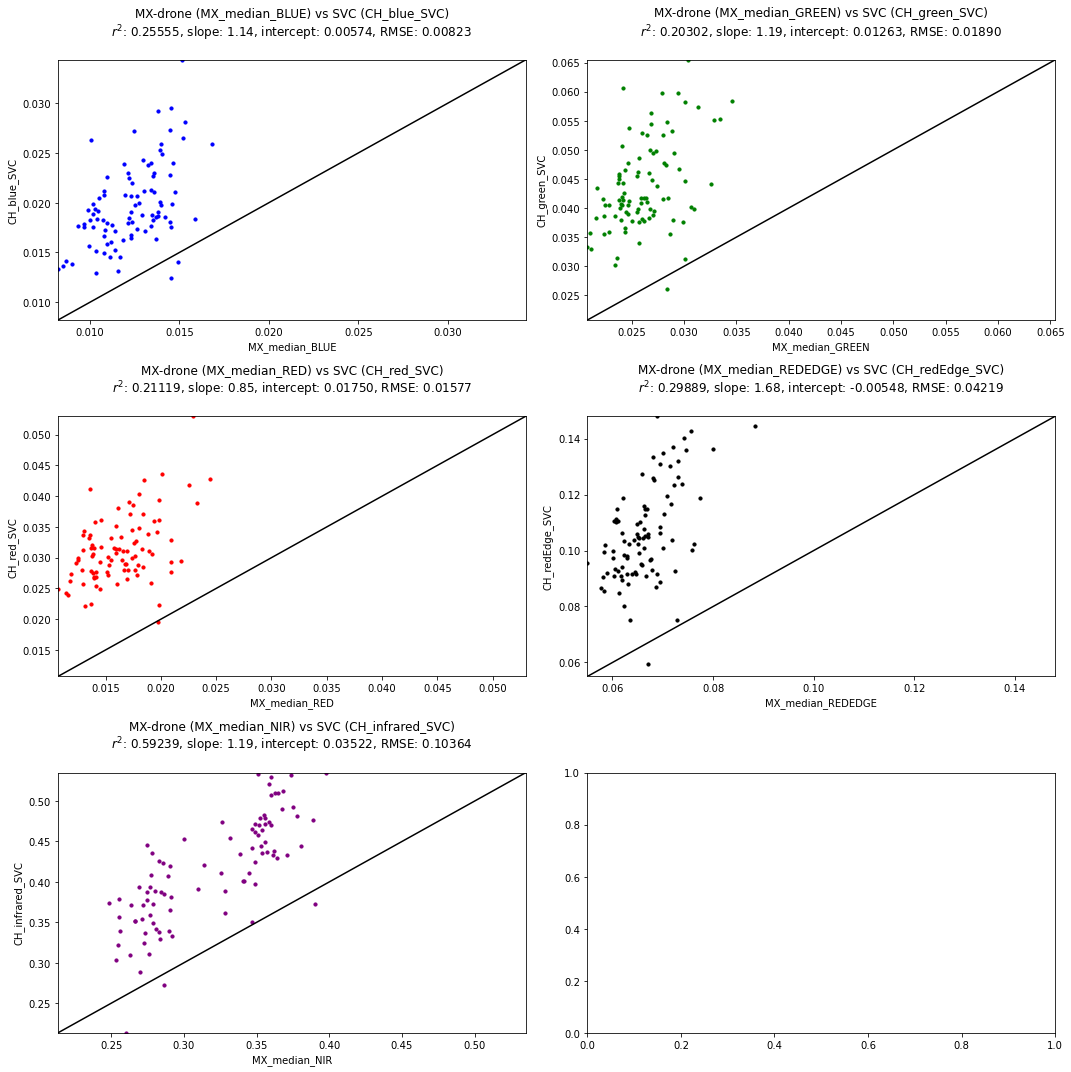

In [6]:
fig, axarr = plt.subplots(3,2, figsize=(15,15))
validation_plot('MX_median_BLUE', 'CH_blue_SVC',df_stats,  ax=axarr[0][0], alpha=1, c='blue')
validation_plot('MX_median_GREEN', 'CH_green_SVC',df_stats, ax=axarr[0][1], alpha=1, c='green')
validation_plot('MX_median_RED', 'CH_red_SVC',df_stats,  ax=axarr[1][0], alpha=1, c='red')
validation_plot('MX_median_REDEDGE', 'CH_redEdge_SVC',df_stats, ax=axarr[1][1], alpha=1, c='k')
validation_plot('MX_median_NIR', 'CH_infrared_SVC',df_stats,  ax=axarr[2][0], alpha=1, c='purple')
fig.tight_layout()

## 3. Valores mediana - NDVI

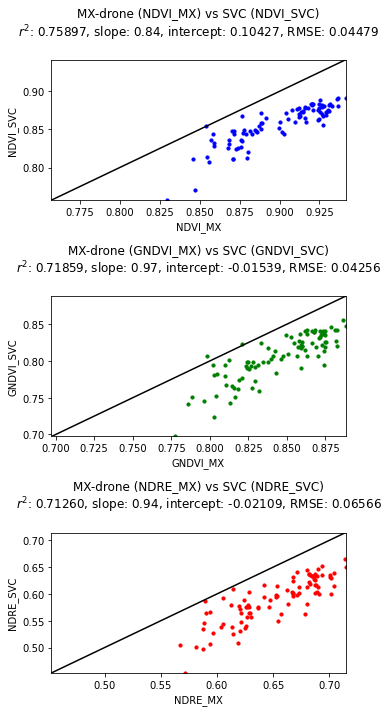

In [39]:
fig, axarr = plt.subplots(3,1, figsize=(5,10))
validation_plot('NDVI_MX', 'NDVI_SVC',df_stats,  ax=axarr[0], alpha=1, c='blue')
validation_plot('GNDVI_MX', 'GNDVI_SVC',df_stats, ax=axarr[1], alpha=1, c='green')
validation_plot('NDRE_MX', 'NDRE_SVC',df_stats,  ax=axarr[2], alpha=1, c='red')

fig.tight_layout()

In [32]:
df_stats.columns

Index(['id', 'file_name', 'index', 'file_path', 'instrument_type',
       'integration_time', 'measurement_type', 'gps_time_ref', 'gps_time_tgt',
       'longitude_ref', 'longitude_tgt', 'latitude_ref', 'latitude_tgt',
       'error_ref', 'error_tgt', 'wavelength_min', 'wavelength_max', 'filas',
       'columnas', 'tipo', 'fila_plantilla', 'columna_plantilla', 'id_josefin',
       'tipo_plantilla', 'repeticion', 'numero_variedad', 'nombre_variedad',
       'geometry', 'MX_min_BLUE', 'MX_max_BLUE', 'MX_mean_BLUE', 'MX_std_BLUE',
       'MX_median_BLUE', 'MX_min_GREEN', 'MX_max_GREEN', 'MX_mean_GREEN',
       'MX_std_GREEN', 'MX_median_GREEN', 'MX_min_RED', 'MX_max_RED',
       'MX_mean_RED', 'MX_std_RED', 'MX_median_RED', 'MX_min_REDEDGE',
       'MX_max_REDEDGE', 'MX_mean_REDEDGE', 'MX_std_REDEDGE',
       'MX_median_REDEDGE', 'MX_min_NIR', 'MX_max_NIR', 'MX_mean_NIR',
       'MX_std_NIR', 'MX_median_NIR', 'CH_blue_SVC', 'CH_green_SVC',
       'CH_red_SVC', 'CH_redEdge_SVC', 'CH_infrar